In [1]:
%load_ext autoreload
%autoreload 2

In [74]:
from __future__ import division, print_function

import os, sys
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
plt.rcParams['image.cmap'] = 'gist_earth'

import sklearn.metrics as metrics
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

from PIL import Image
import time


%matplotlib inline

### Main code

In [1]:
%%writefile precision_recall.py

def get_nestlist(arr, i, j, rho=1,value=False):
    """Return d-th neighbors of cell (i, j)"""

    if arr.ndim != 2:
        raise ValueError("need 2-D input")    
        
    def get_nbr_list(d):
        if d==0:
            dth_nbr_list=[(i,j)]
        else:
            #----- left side -----
            ilc = np.clip(i - d, 0, arr.shape[0]-1)
            jlc = j
            #
            ilu = ilc
            jlu = np.clip(j + d, 0, arr.shape[1]-1)
            #
            ild = ilc
            jld = np.clip(j - d, 0, arr.shape[1]-1)
            #----- right side ----
            irc = np.clip(i + d, 0, arr.shape[0]-1)
            jrc = j
            #
            iru = irc
            jru = np.clip(j + d, 0, arr.shape[1]-1)
            #
            ird = irc
            jrd = np.clip(j - d, 0, arr.shape[1]-1)
            #----- top and bottom ---
            it = i
            jt = np.clip(j + d, 0, arr.shape[1]-1)
            #
            ib = i
            jb = np.clip(j - d, 0, arr.shape[1]-1)

            dth_nbr_list = [(it,jt),(ib,jb), 
                    (ird,jrd), (irc,jrc), (iru,jru),
                    (ild,jld), (ilc,jlc), (ilu,jlu)]
        return dth_nbr_list
    
    #get neighbour list
    nbr_list = []
    for d in range(0,rho+1):
        nbr_list.extend(get_nbr_list(d))

    #order of output is random for now
    if not value:
        return nbr_list
    else:
        return np.array([ arr[ix] for ix in nbr_list ])
    

def findIntersection(fun1,fun2,x0):
    return fsolve(lambda x : fun1(x) - fun2(x),x0)            
    
class roc_eval(object):
    
    def __init__(self,gt_list,pred_list,
                 rho=0,threshold=None,
                background=None,obj=None,
                 verbose=0, plot=False, 
                 diagline=True):
        
        self.gt_list = gt_list
        self.pred_list = pred_list
        self.rho = rho
        self.threshold = threshold 
        self.background = background, 
        self.obj = obj
        self.verbose = verbose
        self.plot_diagline = diagline
        
        self.stat = self.precision_recall(gt_list, pred_list)
        
        if plot:
            self.plot_roc_curve(data=self.stat['ax_data'])
            
    def precision(self,x=None): 
        #return self.stat.
        if x is None:
            x = self.threshold
        return self.fvalue('precision')(x)
    
    def recall(self,x=None): 
        #return self.stat.
        if x is None:
            x = self.threshold
        return self.fvalue('recall')(x)
    
    def fp(self,x=None): 
        #return self.stat.
        if x is None:
            x = self.threshold
        return self.fvalue('FP')(x)
    
    def fn(self,x=None): 
        #return self.stat.
        if x is None:
            x = self.threshold
        return self.fvalue('FN')(x)
    
    def f1_score(self,x=None):
        p = self.precision(x)
        r = self.recall(x)
        return 2 * (p * r) / (p + r) 
    
    def auc(self,name='pr'):
        f1,f2 = self.get_stat(name=name, value=True)
        return metrics.auc(f1,f2)
    
    def break_even_point(self,name='pr'):
        x = np.linspace(0,1,1000)
        f1,f2 = self.get_stat(x=x,name=name,value=True)
        f=f1-f2
        zero_crossings = np.where(np.diff(np.sign(f)))[0]
        return np.mean([ f1[zero_crossings[0]],f1[zero_crossings[0]] ])
    
    def get_stat(self, x=None, value=True,name='pr'):
        
        if name=='pr':
            f1=self.fvalue('recall')
            f2=self.fvalue('precision')
        elif name=='roc':
            f1=self.fvalue('FP')
            f2=self.fvalue('FN')    
        else:
            if isinstance(name,(list,tuple)):
                f1=self.fvalue(name[0])
                f2=self.fvalue(name[1])            
            else:
                print('Error: name is unknown!')
                return None, None
            
        #return value or interp func
        if value:
            if x is None:
                x = self.threshold            
            return f1(x), f2(x)
        else:
            return f1, f2
    
    def match_relaxed(self,pixvec,arr,cond='FP'):
        arr_out=[]
        for i in np.ndindex(pixvec.shape):
            if pixvec[i]:            
                pix_list = get_nestlist(arr, i[0], i[1], rho=self.rho,value=True)
                #print(i, pixvec[i], arr[i], cond in pix_list)
                if cond=='FN':
                    arr_out.append( max(pix_list) )
                else:
                    arr_out.append( min(pix_list) )

        return np.array(arr_out)

    def fp_fn_pfnum(self, gtBin, cur_prob, thres):

        assert len(cur_prob.shape) == 2, 'Wrong size of input prob map s'
        assert len(gtBin.shape) == 2, 'Wrong size of input prob map'
        thresInf = np.concatenate(([-np.Inf], thres, [np.Inf]))

        posNum = np.sum(gtBin == True)
        negNum = np.sum(gtBin == False)

        # histogram of false negatives  
        pixvec = (gtBin == True)
        fnArray = self.match_relaxed(pixvec,cur_prob,cond='FN') 
        #fnArray = cur_prob[(gtBin == True)]

        fnHist = np.histogram(fnArray,bins=thresInf)[0]
        fnCum = np.cumsum(fnHist)
        FN = fnCum[0:0+len(thres)];

        #FIXEME: how to compute relaxed FPs?
        pixvec = (gtBin == False)
        fpArray = self.match_relaxed(pixvec,cur_prob,cond='FP') 
        #fpArray = cur_prob[(gtBin == False)]

        fpHist,bin_edge  = np.histogram(fpArray, bins=thresInf)    
        fpCum = np.flipud(np.cumsum(np.flipud(fpHist)))
        FP = fpCum[1:1+len(thres)]

        return FN, FP, posNum, negNum

    def fnfp_to_pr(self, total_fn, total_fp, 
                   total_posnum, total_negnum):

        #calculate precision and recall
        total_tp = total_posnum - total_fn
        total_tn = total_negnum - total_fp
        #print('total_tp, total_tn: ',total_tp, total_tn)
        #
        TP=total_tp 
        TN=total_tn
        FN=total_fn
        FP=total_fp
        P = TP + FN
        N = TN + FP
        TPR = TP / P
        FPR = FP / N

        recall = total_tp / float( total_posnum )
        precision = total_tp / (total_tp + total_fp + 1e-10)
        
        
        #print('total_tp',total_tp)
        #print('recall',recall)
        #print('precision',precision)

        eval_dict = {'recall': recall,
                    'precision': precision,
                    'TPR_wp':TPR,
                    'FPR_wp':FPR,
                    'TP':TP,'TN':TN,
                    'FP':FP,'FN':FN,
                    'ax_data':[{'x':[FPR,'False Positive Rate'],
                                'y':[TPR,'True Positive Rate'],
                                'title':'ROC Curve'},
                              {'x':[recall,'Recall'], 
                               'y':[precision,'Precision'],
                               'title':'Precision-Recall Curve'}]                 
                    }
        

        return eval_dict

    def fvalue(self,name,k='cubic'):
        return interp1d(self.threshold, self.stat[name], 
                        fill_value='extrapolate') #kind=k, 
    
    def precision_recall(self, gt_list=None, 
                         pred_list=None,threshold=None, 
                         verbose=None):
        """."""

        if not verbose is None: 
            self.verbose = verbose
            
        if gt_list is None: 
            gt_list = self.gt_list
            
        if pred_list is None: 
            pred_list = self.pred_list
            
        if not isinstance(gt_list,list):
            gt_list = [gt_list]

        if not isinstance(pred_list,list):
            pred_list = [pred_list]

        gt_dtype = gt_list[0].dtype
        pred_dtype = pred_list[0].dtype

        if pred_dtype==np.float:
            tvec = np.array(range(0, 255))/255.0
        else:
            tvec = [0.5]

        if threshold is None:
            self.threshold = np.array(tvec)
        else:
            self.threshold = np.array(threshold)
            
        #
        threshold = self.threshold
        
        #
        if self.verbose>0:
            print('threshold.shape: ',threshold.shape)
            print('gt_dtype,pred_dtype',gt_dtype,pred_dtype)


        total_fp = np.zeros(threshold.shape)
        total_fn = np.zeros(threshold.shape)
        total_posnum = 0
        total_negnum = 0

        for gt, pred in zip(gt_list, pred_list):
            #    
            FN, FP, posNum, negNum = self.fp_fn_pfnum(gt, pred, threshold)
            #
            if self.verbose>0:
                print('FN, FP, posNum, negNum:',FN, FP, posNum, negNum)
            #
            total_fp += FP
            total_fn += FN
            total_posnum += posNum
            total_negnum += negNum  

        return self.fnfp_to_pr(total_fn, total_fp, total_posnum, total_negnum)

    def plot_roc_ax(self, data, ax=None, drawCol=1, 
                        textLabel = None, title = None, fontsize1 = 24, 
                        fontsize2 = 20, linewidth = 3):

        if ax is None:
            fig, ax = plt.subplots()

        #tableString = 'Algo avgprec Fmax prec recall accuracy fpr Q(TonITS)\n'
        linecol = ['g','m','b','c']
        linesty = ['-','--','-','--']


        if len(data['x'][0])==1: 
            ax.plot(data['x'][0], data['y'][0],'*', markersize=10,
                         label = textLabel, color='k') 
        else:
            if data['x'][1].lower()=='recall':
                data['x'][0]=np.append(data['x'][0],0)
                data['y'][0]=np.append(data['y'][0],1)

            if textLabel is None: textLabel=''
            auc=metrics.auc(data['x'][0], data['y'][0]) 
            #
            if data['x'][1].lower()=='recall':
                print('Precision-Recall AUC: ',auc)
            else:
                print('ROC AUC: ',auc)

            if textLabel:
                textLabel="%s (AUC=%.2f)"%(textLabel, auc)
            else:
                textLabel="AUC=%.2f"%(auc)

            ax.plot(data['x'][0], data['y'][0], linewidth=linewidth, 
                 color=linecol[drawCol], label=textLabel,ls=linesty[drawCol])
        
        
        #draw diagonal line
        if self.plot_diagline:
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            x = np.linspace(xlim[0],xlim[1],100)
            y = np.linspace(ylim[0],ylim[1],100)
            if data['x'][1].lower()=='recall':
                ax.plot(x,y,lw='0.5',color='k')
            else:
                ax.plot(np.flipud(x),y,lw='0.5',color='k')
            
        if textLabel:
            if data['x'][1].lower()=='recall':
                ax.legend(loc='lower left',prop={'size':fontsize2})
            else:
                ax.legend(loc='lower right',prop={'size':fontsize2})

        ax.set_title(data['title'], fontsize=fontsize1)

        #plt.title(title,fontsize=24)
        ax.set_ylabel(data['y'][1],fontsize=fontsize1)
        ax.set_xlabel(data['x'][1],fontsize=fontsize1)

        ax.grid(True)

    def plot_roc_curve(self, data=None,fout=None):

        if not data is None:
            if not isinstance(data, dict):
                stat_dict = {'':data}
            else:
                stat_dict = data
        else:
            stat_dict = {'':self.stat['ax_data']} 

        
        names = stat_dict.keys()

        fig, ax_list = plt.subplots(1,2,figsize=(15,5)) 

        icol=0
        for name, ax_data in stat_dict.iteritems():
            
            for d, ax in zip(ax_data, ax_list):
                
                self.plot_roc_ax(d, ax=ax,
                            fontsize1 = 16,
                            fontsize2 = 16, 
                            linewidth = 3, 
                            textLabel = name, 
                            drawCol=icol) 
            icol+=1
        #
        if not fout is None:
            plt.savefig( fout )    

Writing precision_recall.py


### Example 

ROC AUC:  0.996687870448
Precision-Recall AUC:  0.989370360456


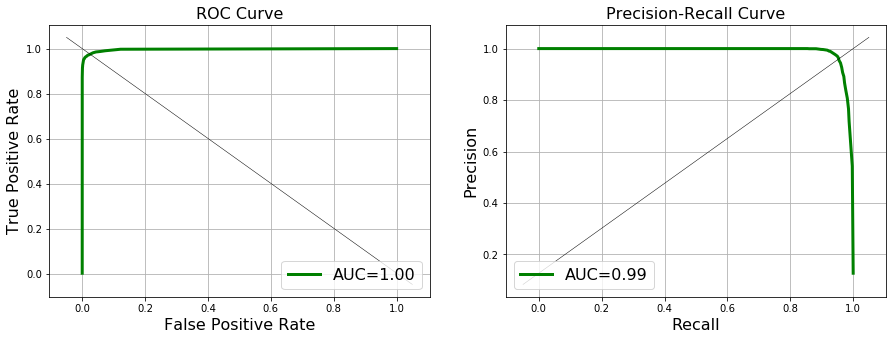

In [128]:
ftest='../data/Boston/valid/labels/label_0.jpeg'
ftest1='../data/Boston/valid/labels/label_1.jpeg'


label = np.asarray(Image.open(ftest),dtype=np.float)/255.0
label[label>0.5]=1
label[label<0.5]=0

label2 = np.asarray(Image.open(ftest),dtype=np.float)/255.0
cnn_image = np.random.random(label.shape)*label2

pr = roc_eval(label, cnn_image,rho=0,plot=True)

#stat = precision_recall(label, cnn_image,rho=0)

#plot_roc_curve(stat['ax_data'])


In [129]:
pr.break_even_point()

0.95482514214502689

In [120]:
f1,f2 = pr.get_stat(value=False)
x = np.linspace(0,1,1000)
f=f1(x)-f2(x)
zero_crossings = np.where(np.diff(np.sign(f)))[0]
print(' zero_crossings', zero_crossings)
print('x, y:',f1(x)[zero_crossings[0]],f2(x)[zero_crossings[0]] )

 zero_crossings [52]
x, y: 0.953932318486 0.953137304786
